In [192]:
from nnsight import NNsight
import torch 
from transformers import GPTJForCausalLM, AutoTokenizer 
from IPython.display import clear_output
from nnsight import LanguageModel
from typing import List, Callable
import torch
import numpy as np
import circuitsvis as cv
import matplotlib.pyplot as plt
import seaborn as sns
 
model_path = "/data/lmm/checkpoints/checkpoint-1953"
gptj = GPTJForCausalLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = LanguageModel(gptj,tokenizer=tokenizer)
torch.set_grad_enabled(False)

In [ ]:
prompt= """| deer | cat | bird |
| deer | cat | cat |
| bird | dog | bird |
The grid above is size 3 by 3. Each cell contains an object from ['deer', 'bird', 'dog', 'cat'].
What object is in row 0, column 0? A: 
"""

layers = model.transformer.h
attn_out = []

with model.trace() as tracer:
    with tracer.invoke(prompt) as invoker:
        for i, layer in enumerate(layers):
            attn_out.append(layer.attn.output.save())



# Access the 'input_ids' attribute of the invoker object to get the input words
input_words = [model.tokenizer.decode(t) for t in invoker.inputs[0]["input_ids"][0]]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
# I think first element is ouput after going through attention heads
# Not sure the difference between the second and third element. I think third is normalized to fall between 0 and 1, not entirely sure

print(len(attn_out))
attn_out[0].shape

12


(torch.Size([1, 66, 768]),
 (torch.Size([1, 12, 66, 64]), torch.Size([1, 12, 66, 64])))

In [220]:
def custom_heatmap(layer, head):
    attention_weights = attn_out[layer][1][0][0][head].squeeze().detach().cpu().numpy() 

    plt.figure(figsize=(10, 8))
    plt.title(f"Attention Weights for Layer {layer} Head {head}")
    sns.heatmap(attention_weights, cmap="coolwarm", annot=False, fmt=".2f", cbar=True, vmin=-20, vmax=20)


In [224]:
def circuitscv(head):
    print(f"Layer {head} Head Attention Patterns:")
    cv.attention.attention_heads(tokens=input_words[:64], attention=attn_out[head][1][0][0])
    

In [223]:
import circuitsvis as cv

print("Layer 0 Head Attention Patterns:")
cv.attention.attention_heads(tokens=input_words[:64], attention=attn_out[0][1][1][0]) 

# attn_out[layer #][1][head #][0]

Layer 0 Head Attention Patterns:


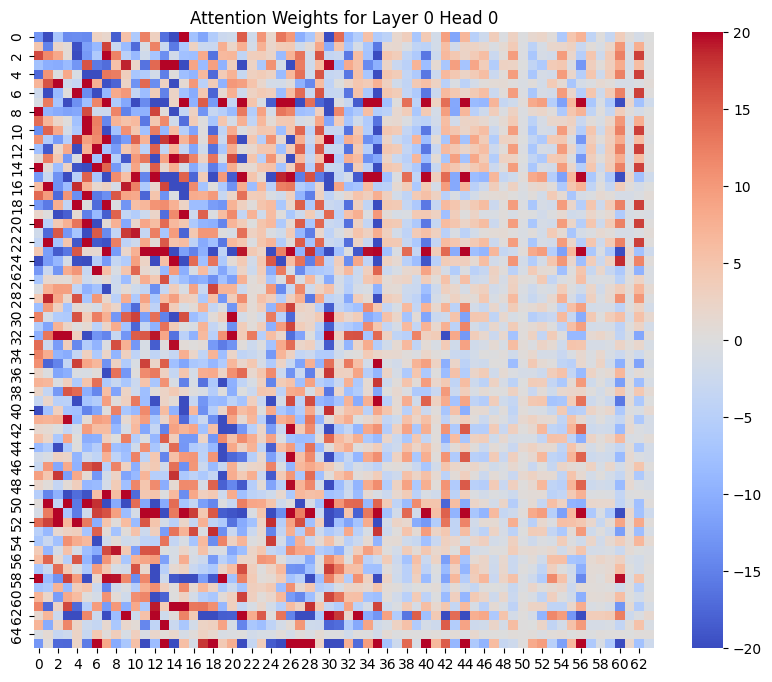

In [225]:
custom_heatmap(0, 0)